**Write the names of all group members (max. 5 members)**:
- FirstName1, LastName1
- FirstName2, LastName2
- FirstName3, LastName3
- Tristan, Þórðarson


# Exercise 1

Consider the Black–Scholes model, in which the evolution of the stock price $S$ is

$$
dS_t = r S_t dt + \sigma S_t dW_t,\quad S_0 = s_0 \in \mathbb{R}_+ \tag{1}
$$

where $W$ is a Brownian motion under a risk-neutral measure $Q$, $\sigma$ is the annualized volatility,
and $r$ is the risk-free interest rate, which we assume to be zero.

Given an option with payoff $g(S_T)$ and maturity $T$, we look for its hedging strategy (i.e. a
trading strategy whose value at maturity is exactly equal to the option payoff), which is the
solution to the following optimization problem:

$$
\inf_{H\in\mathcal{H}} \ \mathbb{E}\!\left[\left( g(S_T) - p - \int_0^T H_u \, dS_u \right)^2\right],
$$

where $\mathcal{H}$ is the set of all predictable processes and $p$ is the risk-neutral option price.

We can solve this problem numerically on a uniform time grid $0 = t_0 < t_1 < \cdots < t_N = T$
by approximating the Itô integral with the discrete stochastic integral $\sum_{j=0}^{N-1} H_{t_j}\cdot (S_{t_{j+1}} - S_{t_j})$,
where $H_{t_0}, \ldots, H_{t_{N-1}}$ are $N$ neural networks jointly trained by minimizing the following empirical
loss

$$
\frac{1}{m}\sum_{i=1}^m \left( g\!\big(s_T^{(i)}\big) - p - \sum_{j=0}^{N-1} H_{t_j}\cdot\big( s_{t_{j+1}}^{(i)} - s_{t_j}^{(i)} \big) \right)^2 \tag{2}
$$

on a training set $D = \big( (s_{t_0}^{(i)}, s_{t_1}^{(i)}, \ldots, s_{t_N}^{(i)}), \ 0 \le i \le m \big)$
of $m$ simulated paths of $S$.

Implement and test the model following the steps below:

In [7]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import scipy
from mpl_toolkits.mplot3d import Axes3D # for 3d plotting 

In [8]:
# Set the random seed
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

### Question 1.a

Check that $ S_t = s_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ solves the Black-Scholes SDE.


A process $S$ is said to follow a geometric Brownian motion with constant volatility $\sigma$ and constant drift $\mu$ if it satisfies the stochastic differential equation $dS_t = \sigma S_t \, dW_t + \mu S_t \, dt$, for a Brownian motion $W$. Under risk neutral measure $Q$, drift becomes the risk-free rate as seen in equation (1).

Itô's lemma states that any general (well defined) SDE on the form

$$dX_t = \mu(t,X_t) dt +  \sigma(t,X_t) dW_t$$

can be solved with 

$$ df(t,X_t) = \left(\frac{\partial f}{\partial t}+\mu(t,X_t) \frac{\partial f}{\partial x}+\frac{\sigma^2(t,X_t)}{2} \frac{\partial^2 f}{\partial x^2}\right)dt +\sigma(t,X_t)\frac{\partial f}{\partial x} dW_t$$

let $f(t,X_t) = \ln(X_t)$

$$d(\ln(X_t)) = \left(\mu(t,X_t) \frac{1}{X_t}-\frac{\sigma^2(t,X_t)}{2} \frac{1}{X_t^2}\right)dt +\sigma(t,X_t)\frac{1}{X_t} dW_t$$

and integrate over $[0,t]$ w.r.t. s:

$$\int^{t}_{0} d(\ln(X_s)) = \displaystyle \int^{t}_{0} \left(\mu(s,X_s) \frac{1}{X_s}-\frac{\sigma^2(s,X_s)}{2} \frac{1}{X_t^2}\right)ds + \displaystyle \int^{t}_{0}\sigma(s,X_s)\frac{1}{X_s} dW_s$$

$$ \Leftrightarrow  \ln\left(\frac{X_t}{X_0}\right) = \left(\mu(t,X_t) \frac{1}{X_t}-\frac{\sigma^2(t,X_t)}{2} \frac{1}{X_t^2}\right)t + \sigma(t,X_t)\frac{1}{X_t} W_t $$

Let $\mu(t,X_t) \coloneqq r S_t$, $\sigma(t,X_t) \coloneqq \sigma S_t$ and $X_t \coloneqq S_t$ (as in the formula at top)

$$ \Rightarrow  \ln\left(\frac{S_t}{S_0}\right) = \left(rS_t-\frac{\sigma^2}{2}\right)t + \sigma W_t  \Leftrightarrow S_t = S_0 \exp\left(\left(rS_t-\frac{\sigma^2}{2}\right)t + \sigma W_t\right)$$

And if we assume $r = 0$ then 

$$ S_t = S_0 \exp\left(\sigma W_t-\frac{\sigma^2 t}{2} \right) \quad \textbf{q.e.d}$$





### Question 1.b - Generate dataset

Simulate a training set of $10^5$ paths and a test set of $10^4$ paths for the asset $S$ with
parameters $N = 30$, $S_{t_0} = s_0 = 1$, $T = 1$ month $= 30/365$, $\sigma = 0.5$.

The process $S$ can be simulated exactly on a finite grid by setting

$$
S_{t_{j+1}} = S_{t_j} \exp\!\left( -\frac{\sigma^2}{2}\frac{T}{N} + \sigma \sqrt{\frac{T}{N}}\, Z_{j+1} \right),
$$

where $Z_1, \ldots, Z_N$ are $N$ iid standard Gaussian random variables.


In [ ]:
n_train = 10**5
n_test = 10**4
N = 30
S0 = 1
T = 30/365
sigma = 0.5

Z = torch.randn(n_train+n_test,N+1,dtype=torch.float64)
a = - (sigma**2)/2 * (T/N) * torch.ones(N+1) # add comments!

S = torch.zeros(n_train+n_test,N+1,dtype=torch.float64)
S[:,0] = torch.ones_like(S[:,0])
for t in range(N):
    b = sigma*(T/N)**(0.5) * Z[:,t+1]
    S[:,t+1] = S[:,t]*torch.exp(a[t]+b)

# Generate the training set
S_train = S[:n_train,:]
# Generate the test set
S_test = S[n_train:,:]



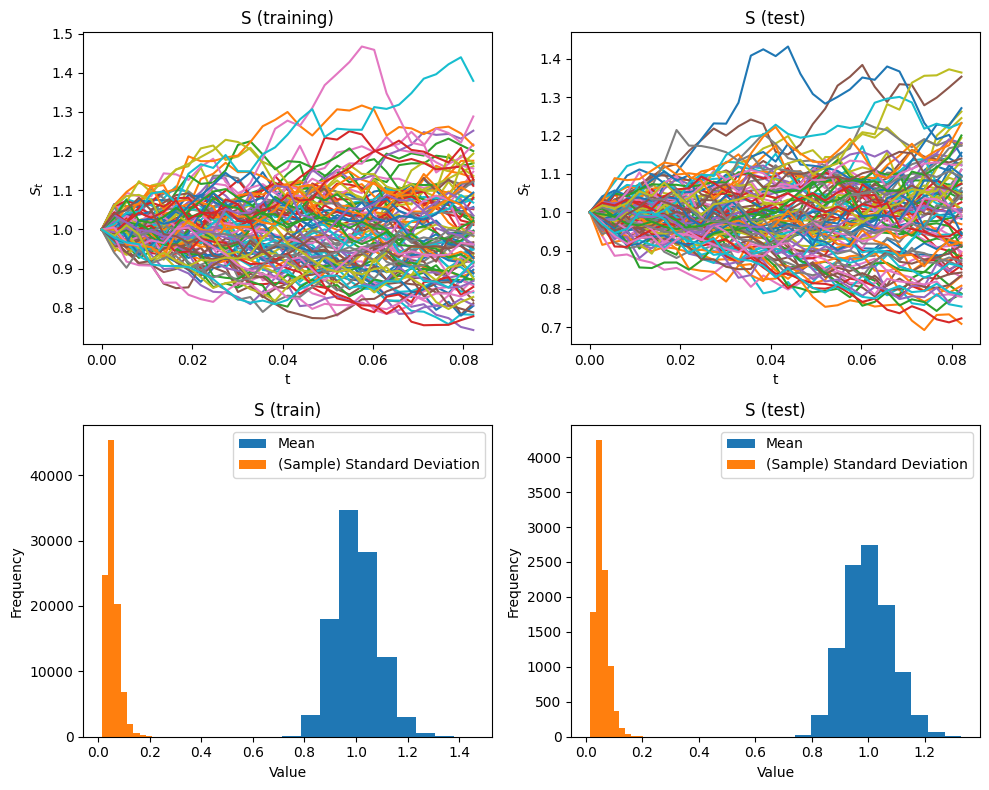

In [10]:
# Quickly plot the paths
t_grid = np.linspace(0,N,N+1)/365
fig1,axs1 =plt.subplots(2, 2, figsize=(10, 8))
axs1[0,0].plot(t_grid,S_train[0:100,:].T)
axs1[0,0].set_xlabel("t")
axs1[0,0].set_ylabel(f"$S_t$")
axs1[0,0].set_title("S (training)")

axs1[0,1].plot(t_grid,S_test[0:100,:].T)
axs1[0,1].set_xlabel("t")
axs1[0,1].set_ylabel(f"$S_t$")
axs1[0,1].set_title("S (test)")

axs1[1,0].hist(S_train.mean(dim=1),label="Mean")
axs1[1,0].hist(S_train.std(dim=1),label="(Sample) Standard Deviation")
axs1[1,0].legend()
axs1[1,0].set_xlabel("Value")
axs1[1,0].set_ylabel("Frequency")
axs1[1,0].set_title("S (train)")

axs1[1,1].hist(S_test.mean(dim=1),label="Mean")
axs1[1,1].hist(S_test.std(dim=1),label="(Sample) Standard Deviation")
axs1[1,1].legend()
axs1[1,1].set_xlabel("Value")
axs1[1,1].set_ylabel("Frequency")
axs1[1,1].set_title("S (test)")

plt.tight_layout()
plt.show()

### Question 1.c - Model implementation

Implement the model by defining each $H_{t_{j}} : R → R$ as a neural network with input $S_{t_{j}}$.

In [ ]:
def create_nets(InDim=1,nh1=32,nh2=32,OutDim=1,N=N):
    nets = []
    for t in range(N):
        network = nn.Sequential(
        nn.Linear(InDim, nh1),
        nn.ReLU(), 
        nn.Linear(nh1, nh2), 
        nn.ReLU(), 
        nn.Linear(nh2, OutDim)).double()  
        
        nets.append(network)
    return nets

In [ ]:
H_nets = create_nets()

We construct the deep hedging model consisting of N=30 separate neural networks, one for each trading time step $t_j$. Each network $H_{t_j}: \mathbb{R} \to \mathbb{R}$ takes as input the current stock price $S_{t_j}$ and outputs the optimal number of shares to hold. We use a simple feedforward architecture with two hidden layers of 32 neurons each and ReLU activations.

### Question 1.d - Model training

Train the deep hedging model for a call option with payoff $g(S_T) := (S_T - K)^+$, with strike
$K = 1$ and maturity $T = 1$ month $= 30/365$, by minimizing the loss (2) on the training set.

To compute the risk neutral price $p$, recall that in the Black–Scholes model, the value of a
European call option at time $t$, denoted by $C(S_t, t)$, can be computed explicitly and is a
function of the value of the risky asset $S_t$ and of time $t$:

$$
C(S_t, t) = \Phi(d_+) S_t - \Phi(d_-) K e^{-r(T - t)}
\tag{3}
$$


where

$$
d_+ = \frac{1}{\sigma \sqrt{T - t}} \left( \log\!\left( \frac{S_t}{K} \right) + \left( r + \frac{\sigma^2}{2} \right) (T - t) \right),
$$

$\Phi$ is the standard Gaussian cumulative distribution function, and
$$
d_- = d_+ - \sigma \sqrt{T - t}.
$$

You can compute the risk-neutral price $p := C(S_0, 0)$ using (3).


In [11]:
K = 1
r = 0

def call_payoff(S_T,K=1):
    return torch.relu(S_T-K)

def BS_call_price(S_t,t=0,K=1,T=30/365,r=0,sigma=0.5):
    # Comment!
    tau = torch.tensor(T-t)
    tau_sq = torch.sqrt(tau)
    d_p = 1/(sigma*tau) * (torch.log(S_t/K)+(r+sigma**2/2)*tau)
    d_m = d_p - sigma*tau_sq
    Phi = torch.distributions.Normal(0,1)

    return Phi.cdf(d_p)*S_t-Phi.cdf(d_m)*K*torch.exp(-r*tau)


p = BS_call_price(torch.tensor(S0))
y_train = call_payoff(S_train[:,-1],K)
y_test = call_payoff(S_test[:,-1],K)

training_dataset = TensorDataset(S_train,y_train)
test_dataset = TensorDataset(S_test,y_test)

n_epochs = 100
lr = 1e-2
batch_size = 1000

network_params = []
for net in H_nets:
    network_params += list(net.parameters())

opt = torch.optim.Adam(network_params, lr=lr)

train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

losses = []
training_loop = tqdm(range(n_epochs))

for epoch in training_loop:
    for paths, _ in train_loader:
        opt.zero_grad()
        dS = paths[:, 1:] - paths[:, :-1]
        H_all = torch.cat(
            [H_nets[t](paths[:, t].unsqueeze(1)) for t in range(N)],
            dim=1
        )
        hedge_gain = (H_all * dS).sum(dim=1)
        payoff = call_payoff(paths[:, -1])
        hedge_err = (payoff - p - hedge_gain)

        loss = (hedge_err**2).mean()
        loss.backward()
        opt.step()

    losses.append(loss.item())
    training_loop.set_postfix(loss=loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(np.log(losses))
plt.ylabel("Log loss")
plt.xlabel("Epoch")
plt.show()

### Question 1.e - Model evaluation

Evaluate the hedging portfolio losses at maturity, i.e.
$$
g(S_T) - p - \sum_{j=0}^{N-1} H_{t_j}\cdot\big( S_{t_{j+1}} - S_{t_j} \big),
$$
on the test set. Plot their histogram and print their empirical mean and standard deviation.


In [ ]:
# Evaluate the hedging losses on the test set
hedge_sum_test = 0
for t in range(N):
    h_t = H_nets[t](test_dataset.tensors[0][:,t].unsqueeze(1)) 
    dS_t = (test_dataset.tensors[0][:,t+1]-test_dataset.tensors[0][:,t]).unsqueeze(1) 
    hedge_sum_test += ((h_t * dS_t).squeeze(1)) 

loss_test = (y_test - p - hedge_sum_test).detach().numpy()

# Plot a histogram of the hedging losses and print mean and standard deviation
plt.hist(loss_test,bins=50)
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()

print(f"Mean = {loss_test.mean():.3e}\n(Sample) Standard Deviation = {loss_test.std(ddof=1):.3e}")


### Question 1.f

In the Black–Scholes model, the hedging problem admits an analytical solution given by

$$
H^{BS}_t(s) = \frac{\partial C(s,t)}{\partial s}.
$$

### Question 1.f(i) - Compute analytical solution

Show a **step-by-step** derivation of the analytical hedging strategy:

\begin{align*}
H^{\text{BS}}_t(s) & = \frac{\partial C(s, t)}{\partial s} \\
& = \frac{\partial}{\partial s} \left[ s\Phi(d_+)-K\Phi(d_-)e^{-r(T-t)} \right]  \\
& = \Phi(d_+)+s\partial_s(\Phi(d_+)) - K\partial_s(\Phi(d_-))e^{-r(T-t)} \\
& = \Phi(d_+)+s\left(\frac{s}{\sigma\sqrt{T-t}}\right)\Phi'(d_+) - K\left(\frac{1}{s\sigma\sqrt{T-t}}\right)\Phi'(d_-)e^{-r(T-t)} \\
& = \Phi(d_+)+\frac{1}{\sigma\sqrt{T-t}\sqrt{2\pi}}\exp(-(d_+)^2/2)-\frac{K}{s\sigma\sqrt{T-t}\sqrt{2\pi}}\exp(-(d_-)^2/2)e^{-r(T-t)} \\
& = \Phi(d_+)+\frac{1}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(\exp\left(-\frac{(d_+)^2}{2}\right)-\frac{Ke^{-r(T-t)}}{s} \exp\left(-\frac{(d_-)^2}{2}\right)\right) \\
& = \Phi(d_+)+\frac{1}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(\exp\left(-\frac{(d_+)^2}{2}\right)-\frac{Ke^{-r(T-t)}}{s} \exp\left(-\frac{(d_+-\sigma\sqrt{T-t})^2}{2}\right)\right) \\
& = \Phi(d_+) +\frac{1}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(\exp\left(\frac{-d^2_+}{2}\right)-\frac{K e^{-r(T-t)}}{s}\exp\left(\frac{-d_+^2+2d_+\sigma\sqrt{T-t}-\sigma^2({T-t})}{2}\right)\right) \\
& = \Phi(d_+)+\frac{\exp\left(\frac{-d^2_+}{2}\right)}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(1-\frac{K e^{-r(T-t)}}{s}\exp\left(\frac{2d_+\sigma\sqrt{T-t}-\sigma^2({T-t})}{2}\right)\right) \\
& = \Phi(d_+)+\frac{\exp\left(\frac{-d^2_+}{2}\right)}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(1-\frac{K e^{-r(T-t)}}{s}\exp\left(\frac{2\left(\ln(s/K)+\left(r+\frac{\sigma^2}{2}(T-t)\right)\right)-\sigma^2({T-t})}{2}\right)\right) \\
& = \Phi(d_+)+\frac{\exp\left(\frac{-d^2_+}{2}\right)}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(1-\frac{K}{s}\exp\left(\ln(s/K)\right)\right) \\
& = \Phi(d_+)+\frac{\exp\left(\frac{-d^2_+}{2}\right)}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(1-1\right) \\
& = \Phi(d_+) \\
\end{align*}


### Question 1.f(ii) - Losses comparison with analytical solution

Evaluate the hedging portfolio losses on the test set when using the analytical hedging
strategy $H^{BS}$ to rebalance the hedging portfolio at the trading dates $t_0, t_1, \ldots, t_{N-1}$.
Plot their histogram and print their empirical mean and standard deviation. Compare
with the results obtained in Ex.1(e). (Hint: make sure your deep hedging model
performs similarly to the analytical hedging strategy)

In [ ]:
# Implement the formula you found
def H_bs(S_t,t=0,r=0,K=1,T=30/365,sigma=0.5):
    tt = torch.tensor(T-t)
    tt_sq = torch.sqrt(tt)
    d_p = 1/(sigma*tt_sq) * (torch.log(S_t/K)+(r+sigma**2/2)*tt)
    Phi = torch.distributions.Normal(0,1)
    return  Phi.cdf(d_p)

# Evaluate the losses of the analytical hedging strategies on the test set
hedge_bs_sum_test = 0
dt = T / N

for t in range(N):
    tau_t = t * dt
    h_bs_t = H_bs(test_dataset.tensors[0][:,t].unsqueeze(1),t=tau_t) # ([b] --> [b,1])
    dS_bs_t = (test_dataset.tensors[0][:,t+1]-test_dataset.tensors[0][:,t]).unsqueeze(1) # [b] --> [b,1]
    hedge_bs_sum_test += ((h_bs_t * dS_bs_t).squeeze(1)) # [b,1] --> [b]

loss_bs_test = (y_test - p - hedge_bs_sum_test).detach().numpy()
# Plot a histograms of the hedging losses (analytical and deep hedging) and print means and standard deviations
plt.hist(loss_test,bins=50,label="Deep Hedge")
plt.hist(loss_bs_test,bins=50,label="Analytical Hedge")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print("## Deep Hedge  ")
print(f"\tMean = {loss_test.mean():.3e}\n\t(Sample) Standard Deviation = {loss_test.std(ddof=1):.3e}")
print("## Analytical Hedge  ")
print(f"\tMean = {loss_bs_test.mean():.3e}\n\t(Sample) Standard Deviation = {loss_bs_test.std(ddof=1):.3e}")

How does your deep hedging model compare with the analytical solution? If it's worse, you must improve its performance. A few questions for you to consider...

Have you trained your deep hedging model well?
- Are the losses centered on zero? ($10^{-5} \approx 0$)
- Is their standard deviation comparable with that of the analytical solution?

How can you improve performance?
- train for more epochs
- try a different learning rate
- change the networks' architectures (first try more hidden neurons, then try more hidden layers)
- try different batch sizes
- use a learning rate scheduler (see https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- try a different activation function (e.g. $\tanh$)
- implement regularization (use the `weight_decay` argument in the optimizer)
- implement batch-normalization (see https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
- experiment with different optimizers
- ask in the forum

#### Notes on the approach
As observed the loss of the deep hedging strategy is rather close the one obtained via analytical solution, nevertheless one could try to minimized it further (while staying clear of overfitting ofcourse).

Suggestions:

Since the networks $H_{t_j}$ are relatively shallow (and do not necessarily need to be any deeper) one could quickly study them with the Neural Tangent Kernel ([NTK](https://arxiv.org/abs/1806.07572)), derive the "NTK"-matrix which will take no time (if the network is shallow), find eigenvalues and approximate the learning rate (such that the system/network stays stable throughout training). Note that we do not implement this in this project, the computations are a bit delegate. (Notably one of the group members wrote a Python and Julia package to explicitly study networks within this frame).

One needs to be careful thought since there is a set of networks, which brings us to the next suggestion, which is, training a single network that takes care of all time steps hence takes time in as input and the network becomes a mapping $H_t : \mathbb{R}^2 \to \mathbb{R}$.

In [ ]:
H_net_2 = create_nets(InDim=2, N=1)[0].double()
opt_2 = torch.optim.Adam(H_net_2.parameters(), lr=lr)

train_loader_2 = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
p_2 = BS_call_price(torch.tensor(S0))
losses_2 = []
training_loop_2 = tqdm(range(n_epochs))

for epoch_2 in training_loop_2:
    for paths_2, _ in train_loader_2:

        opt_2.zero_grad()

        # price increments
        dS_2 = paths_2[:, 1:] - paths_2[:, :-1]

        # hedge ratios through time
        H_all_2 = []
        for t_2 in range(N):
            t_tensor_2 = torch.full(
                (paths_2.size(0), 1),
                float(t_2) / N,
                device=paths_2.device,
                dtype=torch.double
            )
            S_tensor_2 = paths_2[:, t_2].unsqueeze(1).double()

            # ★ FIX: concatenate before passing to Sequential net
            H_input_2 = torch.cat([t_tensor_2, S_tensor_2], dim=1)

            H_t_2 = H_net_2(H_input_2)
            H_all_2.append(H_t_2)

        H_all_2 = torch.cat(H_all_2, dim=1)

        # hedge P&L
        hedge_gain_2 = (H_all_2 * dS_2).sum(dim=1)

        payoff_2 = call_payoff(paths_2[:, -1])
        hedge_err_2 = payoff_2 - p_2 - hedge_gain_2

        loss_2 = (hedge_err_2**2).mean()
        loss_2.backward()
        opt_2.step()

    losses_2.append(loss_2.item())
    training_loop_2.set_postfix(loss=loss_2.item())


In [ ]:
hedge_sum_multi_test_2 = 0

for t_2 in range(N):
    tau_t_2 = t_2 * dt

    X_2 = torch.stack([
        torch.full_like(S_test[:, t_2], tau_t_2 / (N * dt)),   
        S_test[:, t_2]
    ], dim=1).double()

    h_t_2 = H_net_2(X_2)          
    dS_t_2 = (S_test[:, t_2 + 1] - S_test[:, t_2]).unsqueeze(1).double()
    hedge_sum_multi_test_2 += (h_t_2 * dS_t_2).squeeze(1)
    
loss_multi_test_2 = (y_test - p_2 - hedge_sum_multi_test_2).detach().numpy()


In [ ]:
plt.plot(torch.log(torch.tensor(losses_2)),label="Deep Hedge (Single Network)")
plt.plot(torch.log(torch.tensor(losses)),label="Deep Hedge")
plt.legend()
plt.ylabel("Log loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
# Plot both the deep hedging strategies and the analytical hedging strategies
plt.hist(loss_test,bins=50,
        label=fr"$\bf{{Deep Hedge}}$"+f"\n$\hat{{\mu}}$ = {loss_test.mean():.3e}\n$\hat{{\sigma}}$= {loss_test.std(ddof=1):.3e}",)
plt.hist(loss_multi_test_2,bins=50,
        label=fr"$\bf{{Deep Hedge (Single Network)}}$"+f"\n$\hat{{\mu}}$ = {loss_multi_test_2.mean():.3e}\n$\hat{{\sigma}}$ = {loss_multi_test_2.std(ddof=1):.3e}",
        histtype='step',linewidth=2.0)
plt.hist(loss_bs_test,bins=50,
        label=fr"$\bf{{Analytical Hedge}}$"+f"\n$\hat{{\mu}}$ = {loss_bs_test.mean():.3e}\n$\hat{{\sigma}}$ = {loss_bs_test.std(ddof=1):.3e}")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
mu_2 = []
h_multi_2 = []
h_old_2 = []
h_bs_2 = []
multi_diff_2 = []
old_diff_2 = []
X_2 = []
i_2 = 0
mse_multi_list = []
mse_old_list = []


for t_2 in range(N):
    tau_t_2 = t_2 * dt

    X_2.append(torch.stack([
        torch.full_like(S_test[:, t_2], float(t_2)/N),
        S_test[:, t_2]
    ], dim=1).double())

    h_multi_2.append(H_net_2(X_2[i_2]).detach())
    h_old_2.append(H_nets[t_2](S_test[:, t_2].unsqueeze(1)).detach())
    h_bs_2.append(H_bs(S_test[:, t_2].unsqueeze(1), t=tau_t_2).detach())

    multi_diff_2.append((h_multi_2[i_2] - h_bs_2[i_2]).detach())
    old_diff_2.append((h_old_2[i_2] - h_bs_2[i_2]).detach())

    mu_2.append(max(multi_diff_2[i_2].abs().max(), old_diff_2[i_2].abs().max()).item())
    mse_multi_list.append(multi_diff_2[i_2].pow(2).mean().item())
    mse_old_list.append(old_diff_2[i_2].pow(2).mean().item())

    i_2 += 1

j_2 = 0
fig_2, axes_2 = plt.subplots(int(N/4 + 1), 2, figsize=(12, 20))

for t_2 in range(1, N, 4):
    axes_2[j_2, 0].plot(S_test[:, t_2], h_multi_2[t_2], '.', label="Deep Hedge (Single Net)", color='blue')
    axes_2[j_2, 0].plot(S_test[:, t_2], h_bs_2[t_2], '.', label="Analytical Hedge", color='green')
    axes_2[j_2, 0].plot(S_test[:, t_2], h_old_2[t_2], '.', label="Deep Hedge (Multi-Net)", color='orange')

    axes_2[j_2, 0].set_title(f"Hedge at time t = {t_2}")
    axes_2[j_2, 0].set_ylabel(r"$\Delta(S_t)$")
    axes_2[j_2, 0].set_xlabel(r"$S_t$")
    axes_2[j_2, 0].legend()
    mse_multi = multi_diff_2[t_2].pow(2).mean().item()
    mse_old = old_diff_2[t_2].pow(2).mean().item()

    axes_2[j_2, 1].plot(S_test[:, t_2], multi_diff_2[t_2], '.', color='blue', label=f"Deep Hedge (Single Net) MSE={mse_multi:.3e}")
    axes_2[j_2, 1].plot(S_test[:, t_2], old_diff_2[t_2], '.', color='orange', label=f"Deep Hedge MSE={mse_old:.3e}")
    axes_2[j_2, 1].plot(S_test[:, t_2], multi_diff_2[t_2], '.', color='blue')
    axes_2[j_2, 1].plot(S_test[:, t_2], old_diff_2[t_2], '.', color='orange')
    axes_2[j_2,1].set_ylabel(r"$\Delta_{{Net}} - \Delta_{{BS}}$")
    axes_2[j_2,1].set_xlabel(r"$S_t$")
    axes_2[j_2,1].set_ylim([-max(mu_2), max(mu_2)])
    axes_2[j_2,1].legend()

   
    j_2 += 1

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(mse_multi_list, label="Deep Hedge (Single Net) MSE")
plt.plot(mse_old_list, label="Deep Hegde MSE")
plt.xlabel("Time step t")
plt.ylabel("MSE")
plt.title("MSE of Hedging Error Over Time")
plt.legend()
plt.show()


Note these are the Mean-Squared Residuals which represents the difference between the analytical solution and the network's approximation.

In [ ]:
def plot3d_mesh(h,ax,N=N,S=S_test,difference=False,title="",vmin=None,vmax=None):
    
    if difference:
        h_s = h.squeeze(2)
    else:
        h_s = torch.stack(h,dim=1).squeeze(2)
    
    t_grid = torch.linspace(0,N,N).unsqueeze(0)
    S_sorted, idx = torch.sort(S[:,1:], dim=0) 
    h_sorted = h_s.gather(0,idx)
    ax.plot_surface(S_sorted.detach().numpy(),t_grid.numpy(),h_sorted.detach().numpy(),
                    cmap='coolwarm',vmin=vmin,vmax=vmax)
    ax.set_ylabel("t")
    ax.set_xlabel("$S_t$")
    ax.set_title(title)
    ax.set_zlabel(f"$\Delta(S_t,t)$",labelpad=-25)

fig3 = plt.figure(figsize=(16, 12))

ax1 = fig3.add_subplot(1, 3, 1, projection='3d')
plot3d_mesh(h_bs_2, ax1, title="Analytical")

ax2 = fig3.add_subplot(1, 3, 2, projection='3d')
plot3d_mesh(h_old_2, ax2, title="Deep Hedge")

ax3 = fig3.add_subplot(1, 3, 3, projection='3d')
plot3d_mesh(h_multi_2, ax3, title="Deep Hedge (Single Network)")


plt.tight_layout()
plt.show()


fig4 = plt.figure(figsize=(12, 12))
diff_old_2 = torch.stack(h_bs_2, dim=1) - torch.stack(h_old_2, dim=1)
diff_new_2 = torch.stack(h_bs_2, dim=1) - torch.stack(h_multi_2, dim=1)
zmax_2 = max(diff_old_2.abs().max().item(), diff_new_2.abs().max().item())

ax4 = fig4.add_subplot(1, 2, 1, projection='3d')
plot3d_mesh(diff_old_2, ax4, difference=True, title="Difference Deep Hedge",
            vmin=-0.2*zmax_2, vmax=0.2*zmax_2)
ax4.set_zlim(-zmax_2, zmax_2)

ax5 = fig4.add_subplot(1, 2, 2, projection='3d')
plot3d_mesh(diff_new_2, ax5, difference=True, title="Difference Deep Hedge (Single Network)",
            vmin=-0.2*zmax_2, vmax=0.2*zmax_2)
ax5.set_zlim(-zmax_2, zmax_2)

plt.tight_layout()
plt.show()




- For what times $t_j$ are the two functions most similar? 


In our simulation we have $S_t = S_0 \exp\bigl((r - \tfrac12\sigma^2)t + \sigma W_t\bigr)$, so $\log S_t$ is normal with variance $\sigma^2 t$. As $t$ increases, the distribution of $S_{t_j}$ becomes wider: at $t_0$ all prices are exactly $S_0 = 1$, while by $t_{29}$ they already cover almost the whole interval $[0.5,1.5]$. Each network $H_{t_j}$ is trained only on the values of $S_{t_j}$ that appear in the simulated paths. For $t_0$ this is basically just the single input $s = 1$, so the network learns the hedge at $s=1$, but it does not really learn how the hedge should change with $s$. As a result, $H_{t_0}(s)$ is almost flat on $[0.5,1.5]$ and clearly different from the analytical hedge. When $j$ increases, the training data for $H_{t_j}$ contain prices in a much larger range, especially around the strike $K = 1$, so the network has to learn the full shape of $s \mapsto H^{BS}{t_j}(s)$. By $t{29}$, $S_{t_{29}}$ covers almost the whole plotted interval, and $H_{t_{29}}(s)$ matches the analytical delta very well on $[0.5,1.5]$. 

Morever, one may observe the patterns between the two network approaches and how much closer the single network approach is to the analytical solution.

# Exercise 2

Consider now the Heston model, in which the evolution of the stock price $S$ is
$$
\begin{cases}
dS_t = \sqrt{V_t}\, S_t\, dW_t, \quad S_0 = s_0 \in \mathbb{R}_+,\\
dV_t = \tilde{\alpha}(b- V_t)dt+ \sigma \sqrt{V_t}\, dW'_t , \quad V_0 = v_0 \in \mathbb{R}_+,
\end{cases} \tag{4}
$$


where $W$ and $W'$ are two Brownian motions under a risk-neutral measure $Q$ with instantaneous
correlation $\rho \in [-1, 1]$.

In an incomplete market model, such as the Heston model, it is in general impossible to hedge
a payoff $g(S_T)$ perfectly. Instead, we look for a hedging strategy that minimizes the hedging
losses under a risk measure $\pi$ of our choice. Mathematically, this requires solving the following
minimization problem:

$$
p = \inf_{H\in\mathcal{H}} \ \pi\!\left( g(S_T) - \int_0^T H_u \, dS_u \right) \tag{5}
$$


where $p$ is the minimum amount of money needed to erase the hedging risk under the risk
measure $\pi$ and is therefore the price that we would charge for selling the option.

As a particular risk measure, consider $\pi = \mathrm{CVaR}_\alpha$, the expected shortfall at level $\alpha \in (0, 1)$,
defined as:

$$
\mathrm{CVaR}_\alpha(X) = \frac{1}{1-\alpha}\int_\alpha^1 q_u(X)\, du,
$$

where $q_u(X)$ is the $u$-quantile of $X$ under $Q$. Since $\mathrm{CVaR}_\alpha$ admits the representation

$$
\mathrm{CVaR}_\alpha(X) = \inf_{w\in\mathbb{R}} \left( w + \frac{1}{1-\alpha}\,\mathbb{E}\big[(X-w)_+\big] \right),
$$

we can reformulate problem (5) as an empirical loss minimization problem for the following loss:

$$
\frac{1}{m}\sum_{i=1}^m \left( w + \frac{1}{1-\alpha}\left( g\big(s_T^{(i)}\big) - \sum_{j=0}^{N-1} H_{t_j}\big( s_{t_{j+1}}^{(i)} - s_{t_j}^{(i)} \big) - w \right)_+ \right), \tag{6}
$$


where we minimize jointly over $w \in \mathbb{R}$ and the $N$ neural networks $H_{t_0}, \ldots, H_{t_{N-1}}$.
Implement and test the model following the steps below:

In [ ]:
s0 = 1
v0 = 0.5
rho = -0.3
alpha_tilde = 4
b = 0.5
v_sigma = 1

N = 30
T = 30/365
dt = T / N
paths_train = 10**5
paths_test  = 10**4

# constant c for value proces
c = (v_sigma**2 / (4 * alpha_tilde)) * (1 - np.exp(-alpha_tilde * dt))
degres_o_f = 4 * b * alpha_tilde / (v_sigma**2)


ii) Now simulate $S$ using the simplified Broadie–Kaya scheme (Andersen et al., 2010):

$$
S_{t_{j+1}} = S_{t_j} \exp\!\left(
\frac{\rho}{\sigma}\Big( (V_{t_{j+1}} - V_{t_j}) - \tilde{\alpha}b\, \frac{T}{N} \Big)
+ \left(\frac{\tilde{\alpha}\rho}{\sigma} - \frac{1}{2}\right) V_{t_j}\frac{T}{N}
+ \sqrt{(1-\rho^2)V_{t_j}\frac{T}{N}}\ Z_{j+1}
\right)
$$

where $Z_1, \ldots, Z_N$ are iid standard Gaussian random variables.

In [ ]:
def sample_V(paths, N, dt, v0, alpha_tilde, b, v_sigma, seed=SEED):
    # constant c for value proces
    c = (v_sigma**2 / (4 * alpha_tilde)) * (1 - np.exp(-alpha_tilde * dt))
    degres_o_f = 4 * b * alpha_tilde / (v_sigma**2)

    V = np.empty((paths, N+1))
    V[:, 0] = v0

    # simulate process Vt according to given formula with c and process Ct
    for j in range(N):

        # noncentral parameter lambda
        lambda_j = np.exp(-alpha_tilde * dt) * (V[:, j] / c)

        # simulate noncentral 
        C_j = scipy.stats.ncx2.rvs(df=degres_o_f, nc=lambda_j, random_state=SEED)

        V[:, j+1] = c * C_j

    return V

def sample_S(V, paths, N, dt, s0, rho, alpha_tilde, b, v_sigma):
    #initiate for datased 
    S = np.empty((paths, N+1))
    S[:, 0] = s0

    # Zi standard normals independant
    Z = np.random.standard_normal(size=(paths, N))

    #simulate St according to the heston price mdoel 
    for j in range(N):

        # drift from Andersen
        drift1 = (rho / v_sigma) * ((V[:, j+1] - V[:, j]) - alpha_tilde * b * dt)

        # second drift 
        drift2 = ((alpha_tilde * rho) / v_sigma - 0.5) * V[:, j] * dt

        # diffusion term
        diffusion = np.sqrt((1 - rho**2) * V[:, j] * dt) * Z[:, j]

        # recursive S
        S[:, j+1] = S[:, j] * np.exp(drift1 + drift2 + diffusion)

    return S

V_train = sample_V(paths_train, N, dt, v0, alpha_tilde, b, v_sigma)
S_train = sample_S(V_train, paths_train, N, dt, s0, rho, alpha_tilde, b, v_sigma)
V_test = sample_V(paths_test, N, dt, v0, alpha_tilde, b, v_sigma)
S_test = sample_S(V_test, paths_test, N, dt, s0, rho, alpha_tilde, b, v_sigma)

S_train_tensor = torch.tensor(S_train)
S_test_tensor = torch.tensor(S_test)
V_train_tensor = torch.tensor(V_train)
V_test_tensor = torch.tensor(V_test)

train_dataset = TensorDataset(S_train_tensor, V_train_tensor)
test_dataset  = TensorDataset(S_test_tensor, V_test_tensor)

In [ ]:
# Quickly plot the paths
t_grid = np.linspace(0,N,N+1)/365
fig1,axs1 =plt.subplots(2, 2, figsize=(10, 8))
axs1[0,0].plot(t_grid,V_train[0:100,:].T)
axs1[0,0].set_xlabel("t")
axs1[0,0].set_ylabel(f"$S_t$")
axs1[0,0].set_title("V (train)")

axs1[0,1].plot(t_grid,V_test[0:100,:].T)
axs1[0,1].set_xlabel("t")
axs1[0,1].set_ylabel(f"$S_t$")
axs1[0,1].set_title("V (test)")

axs1[1,0].hist(V_train_tensor.mean(dim=1),label="Mean")
axs1[1,0].hist(V_train_tensor.std(dim=1),label="(Sample) Standard Deviation")
axs1[1,0].legend()
axs1[1,0].set_xlabel("Value")
axs1[1,0].set_ylabel("Frequency")
axs1[1,0].set_title("V (train)")

axs1[1,1].hist(V_test_tensor.mean(dim=1),label="Mean")
axs1[1,1].hist(V_test_tensor.std(dim=1),label="(Sample) Standard Deviation")
axs1[1,1].legend()
axs1[1,1].set_xlabel("Value")
axs1[1,1].set_ylabel("Frequency")
axs1[1,1].set_title("V (test)")

plt.tight_layout()
plt.show()

fig2, axs2 = plt.subplots(2, 2, figsize=(10, 8))

axs2[0,0].plot(t_grid, S_train[0:100, :].T)
axs2[0,0].set_xlabel("t")
axs2[0,0].set_ylabel("$S_t$")
axs2[0,0].set_title("S (train)")

axs2[0,1].plot(t_grid, S_test[0:100, :].T)
axs2[0,1].set_xlabel("t")
axs2[0,1].set_ylabel("$S_t$")
axs2[0,1].set_title("S (test)")

axs2[1,0].hist(S_train_tensor.mean(dim=1), label="Mean")
axs2[1,0].hist(S_train_tensor.std(dim=1), label="(Sample) Standard Deviation")
axs2[1,0].legend()
axs2[1,0].set_xlabel("Value")
axs2[1,0].set_ylabel("Frequency")
axs2[1,0].set_title("S (train)")

axs2[1,1].hist(S_test_tensor.mean(dim=1), label="Mean")
axs2[1,1].hist(S_test_tensor.std(dim=1), label="(Sample) Standard Deviation")
axs2[1,1].legend()
axs2[1,1].set_xlabel("Value")
axs2[1,1].set_ylabel("Frequency")
axs2[1,1].set_title("S (test)")

plt.tight_layout()
plt.show()

### Question 2.b - Model implementation

Implement the model by defining each $H_{t_j}$ as a neural network with input $(S_{t_j}, V_{t_j})$.


In [ ]:
# Implement the deep hedging model for a generic alpha
# Number of neurons in hidden layers
nh1 = 32 # first hidden layer
nh2 = 32 # second hidden layer

# Create a separate neural network H_j for each time step j
#input is now in contrast to task 1 its V and S
# for two parameters
#alpha = 0.99
H_nets_1,H_nets_2 = create_nets(InDim=2),create_nets(InDim=2)


# H_nets_1 = []
# for j in range(N):
#     net_j = nn.Sequential(
#         nn.Linear(2, nh1), 
#         nn.ReLU(),
#         nn.Linear(nh1, nh2),
#         nn.ReLU(),
#         nn.Linear(nh2, 1)
#     )
#     H_nets_1.append(net_j)

# #alpha = 0.5
# H_nets_2 = []
# for j in range(N):
#     net_j = nn.Sequential(
#         nn.Linear(2, nh1), 
#         nn.ReLU(),
#         nn.Linear(nh1, nh2),
#         nn.ReLU(),
#         nn.Linear(nh2, 1)
#     )
#     H_nets_2.append(net_j)





Unlike in Black-Scholes where we could eliminate all hedging risk, here we need to accept some risk and minimize our worst-case losses. We do this by using CVaR as our risk measure, which focuses on the tail of the loss distribution, we are asking oirselves how bad can things get in the worst scenarios? Our goal is to find a hedging strategy and determine the minimum price p we should charge for the option such that our hedging risk under CVaR is acceptable.

### Question 2.c - Model training

For the same call option considered in Ex. 1, train the model by minimizing the loss (6)
on the training set for two different CVaR levels, $\alpha = 0.5$ and $\alpha = 0.99$.


In [ ]:
# Train two deep hedging models (for alpha=0.5 and alpha=0.99) for the call option
#first
alpha = 0.99

n_epochs = 100
lr = 1e-2
batch_size = 1000

# we learn w
w_1 = torch.nn.Parameter(torch.tensor(0.0))

# parameters
network_parameters = [w_1]
for net in H_nets_1:
    network_parameters += list(net.parameters())

optimizer = torch.optim.Adam(network_parameters, lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75], gamma=0.1)

# train dataset loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

losses_1 = torch.empty(n_epochs)
training_loop = tqdm(range(10))

for epoch in training_loop:

    for (batch_S, batch_V) in train_loader:
        # increments S
        S_increment = batch_S[:, 1:] - batch_S[:, :-1]

        # compute all hedge positions
        hedge_positions = []
        for tj in range(N):
            S_tj = batch_S[:, tj].unsqueeze(1)
            V_tj = batch_V[:, tj].unsqueeze(1)

            # input = (S_tj, V_tj)
            inp = torch.cat([S_tj, V_tj], dim=1)

            H_tj = H_nets_1[tj](inp)
            hedge_positions.append(H_tj)

        # shape (batch, N)
        H = torch.cat(hedge_positions, dim=1)

        # discrete stochastic integral
        hedge_growth = (H * S_increment).sum(dim=1)

        # payoff
        S_T = batch_S[:, -1]
        payoff_T = call_payoff(S_T)

        # hedging loss X = payoff - hedge gains - initial price p
        # here we optimiye p
        X = payoff_T - hedge_growth

        # cvar loos
        loss = w_1 + (1/(1-alpha)) * torch.mean(torch.relu(X - w_1))

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()
    losses_1[epoch] = loss.item()
    training_loop.set_postfix(loss=loss.item())



In [ ]:
# same for alpha 0.5
alpha = 0.99

# we learn another independent w
w_2 = torch.nn.Parameter(torch.tensor(0.0))
H_nets_2 = H_nets_2
# different networks for alpha=0.5
network_parameters = [w_2]
for net in H_nets_2:
    network_parameters += list(net.parameters())

optimizer = torch.optim.Adam(network_parameters, lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75], gamma=0.1)

losses_2 = torch.empty(n_epochs)
training_loop = tqdm(range(10))

for epoch in training_loop:

    for (batch_S, batch_V) in train_loader:
        S_increment = batch_S[:, 1:] - batch_S[:, :-1]

        hedge_positions = []
        for tj in range(N):
            S_tj = batch_S[:, tj].unsqueeze(1)
            V_tj = batch_V[:, tj].unsqueeze(1)

            inp = torch.cat([S_tj, V_tj], dim=1)

            H_tj = H_nets_2[tj](inp)      
            hedge_positions.append(H_tj)

        H = torch.cat(hedge_positions, dim=1)

        hedge_growth = (H * S_increment).sum(dim=1)

        S_T = batch_S[:, -1]
        payoff_T = call_payoff(S_T)

        X = payoff_T - hedge_growth

        loss = w_2 + (1/(1-alpha)) * torch.mean(torch.relu(X - w_2))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()
    losses_2[epoch] = loss.item()
    training_loop.set_postfix(loss=loss.item())




In [ ]:

# plot loss
plt.plot(torch.log(losses_1),label=f"Training loss (alpha=0.99)")
plt.ylabel("Log loss")
plt.xlabel("Epoch")
plt.plot(torch.log(losses_2),label=f"Training loss (alpha=0.5)")
plt.legend()
plt.show()

When $ \alpha = 0.99 $, the model assigns more weight to rare but severe hedging losses. To remain compensated for these extreme scenarios, the seller needs to charge a higher option premium. In contrast, when $\alpha = 0.5$, tail events are given less weight, so the required compensation for risk is lower and the option price comes out lower as well.


### Question 2.d - Price comparison

Compare the prices $p$ for both values of $\alpha$ by evaluating the loss (6) on the test set for each
trained model. Which is higher? Why?


In [ ]:
# w trained
w_alpha05 = w_2.item() 
w_alpha099 = w_1.item()

print("Learned CVaR thresholds w:")
print(f"w (alpha = 0.5):  {w_alpha05}")
print(f"w (alpha = 0.99): {w_alpha099}\n")

#unpack
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# for alfa = 0.5 and 0.99
total_price05 = 0
total_price099 = 0

# we want to go through the dataset and compute losses
for (batch_S, batch_V) in test_loader:
    # increments process od S
    S_increment = batch_S[:, 1:] - batch_S[:, :-1]

    # all hedge positions for this batch
    hedge_positions_099 = []
    hedge_positions_05 = []

    for tj in range(N):
        S_tj = batch_S[:, tj].unsqueeze(1)
        V_tj = batch_V[:, tj].unsqueeze(1)

        inp = torch.cat([S_tj, V_tj], dim=1)

        # get the hedge position H_tj for this time step tj
        hedge_positions_099.append(H_nets_1[tj](inp))
        hedge_positions_05.append(H_nets_2[tj](inp))

    H_099 = torch.cat(hedge_positions_099, dim=1)
    H_05  = torch.cat(hedge_positions_05,  dim=1)
 
    S_T = batch_S[:, -1]
    payoff_T = call_payoff(S_T)

    #hedge growth process
    hedge_growth_099 = (H_099 * S_increment).sum(dim=1)
    hedge_growth_05  = (H_05  * S_increment).sum(dim=1)

    # hedging loss X = payoff - growth
    X_099 = payoff_T - hedge_growth_099
    X_05  = payoff_T - hedge_growth_05

    # equation (6): CVaR price estimate for each batch
    price_099 = w_1 + (1 / (1 - 0.99)) * torch.mean(torch.relu(X_099 - w_1))
    price_05  = w_2 + (1 / (1 - 0.5))  * torch.mean(torch.relu(X_05  - w_2))
    

    # accumulate total loss
    total_price05  += price_05.item()
    total_price099 += price_099.item()

# compute averarege loss ie price p for alfa = 0.5
p_alpha05  = total_price05  / len(test_loader)
p_alpha099 = total_price099 / len(test_loader)
print("Estimated option prices (CVaR):")
print(f"p (alpha = 0.5):  {p_alpha05}")
print(f"p (alpha = 0.99): {p_alpha099}")


### Question 2.e - Price comparison 

In [ ]:
# Plot a histograms of the hedging losses (for alpha=0.5 and alpha=0.99) and print means and standard deviations

# initiate for histogram
all_hedge_errors_05 = []
all_hedge_errors_099 = []

#total
total_loss_05 = 0
total_loss_099 = 0

for (batch_S, batch_V) in test_loader:
    # increments for S
    S_increment = batch_S[:, 1:] - batch_S[:, :-1]

    # hedge posit
    hedge_positions_05 = []
    hedge_positions_099 = []

    for tj in range(N):
        S_tj = batch_S[:, tj].unsqueeze(1)
        V_tj = batch_V[:, tj].unsqueeze(1)

        inp = torch.cat([S_tj, V_tj], dim=1)

        # alfa 05
        H_tj_05 = H_nets_2[tj](inp)
        hedge_positions_05.append(H_tj_05)

        # alfa 099
        H_tj_099 = H_nets_1[tj](inp)
        hedge_positions_099.append(H_tj_099)

    H_05 = torch.cat(hedge_positions_05, dim=1)
    H_099 = torch.cat(hedge_positions_099, dim=1)

    # hedge growth stochastic int
    hedge_growth_05 = (H_05 * S_increment).sum(dim=1)
    hedge_growth_099 = (H_099 * S_increment).sum(dim=1)

    # paoff
    S_T = batch_S[:, -1]
    payoff_T = call_payoff(S_T)

    #hedging losses
    hedge_error_05 = payoff_T - w_2 - hedge_growth_05
    hedge_error_099 = payoff_T - w_1 - hedge_growth_099
    all_hedge_errors_05.append(hedge_error_05.detach().numpy())
    all_hedge_errors_099.append(hedge_error_099.detach().numpy())

    # sum losses
    total_loss_05 += hedge_error_05.sum().item()
    total_loss_099 += hedge_error_099.sum().item()

all_hedge_errors_05 = np.concatenate(all_hedge_errors_05, axis=0)
all_hedge_errors_099 = np.concatenate(all_hedge_errors_099, axis=0)


# histogram hedging errors for both alpha=0.5 and alpha=0.99
plt.hist(all_hedge_errors_05, bins=50, alpha=0.6, label='alpha=0.5', color='blue')
plt.hist(all_hedge_errors_099, bins=50, alpha=0.6, label='alpha=0.99', color='red')
plt.xlabel("Hedging Error")
plt.ylabel("Frequency")
plt.title("Distribution of Hedging Errors for alpha = 0.5 and alpha = 0.99")
plt.legend()
plt.show()

# empirical mean and standard deviation
mean_error_05 = np.mean(all_hedge_errors_05)
std_error_05 = np.std(all_hedge_errors_05, ddof=1)

mean_error_099 = np.mean(all_hedge_errors_099)
std_error_099 = np.std(all_hedge_errors_099, ddof=1)

print(f"Empirical Mean of Hedging Error (alpha=0.5): {mean_error_05}")
print(f"Empirical Std Dev of Hedging Error (alpha=0.5): {std_error_05}")
print(f"Empirical Mean of Hedging Error (alpha=0.99): {mean_error_099}")
print(f"Empirical Std Dev of Hedging Error (alpha=0.99): {std_error_099}")